## All the necessary import statements

In [12]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import cv2
import scipy as sc
import glob
import time
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import seaborn as sns

## Load the data of the vehicle as well as non vehicle class

In [2]:
vehicle_images_gti_far=glob.glob('vehicles/GTI_Far/image*.png')
vehicle_images_gti_left=glob.glob('vehicles/GTI_Left/image*.png')
vehicle_images_gti_right=glob.glob('vehicles/GTI_Right/image*.png')
vehicle_images_kitti=glob.glob('vehicles/KITTI_extracted/*.png')
vehicle_images_middle=glob.glob('vehicles/GTI_MiddleClose/image*.png')

In [3]:
cars=vehicle_images_gti_far+vehicle_images_gti_left+vehicle_images_gti_right+vehicle_images_kitti+vehicle_images_middle

In [4]:
non_vehicle_images_extras=glob.glob('non-vehicles/Extras/extra*.png')
non_vehicle_images_gti=glob.glob('non-vehicles/GTI/*.png')

In [5]:
notcars=non_vehicle_images_extras+non_vehicle_images_gti

## Let us now visualize a few images from the two categories

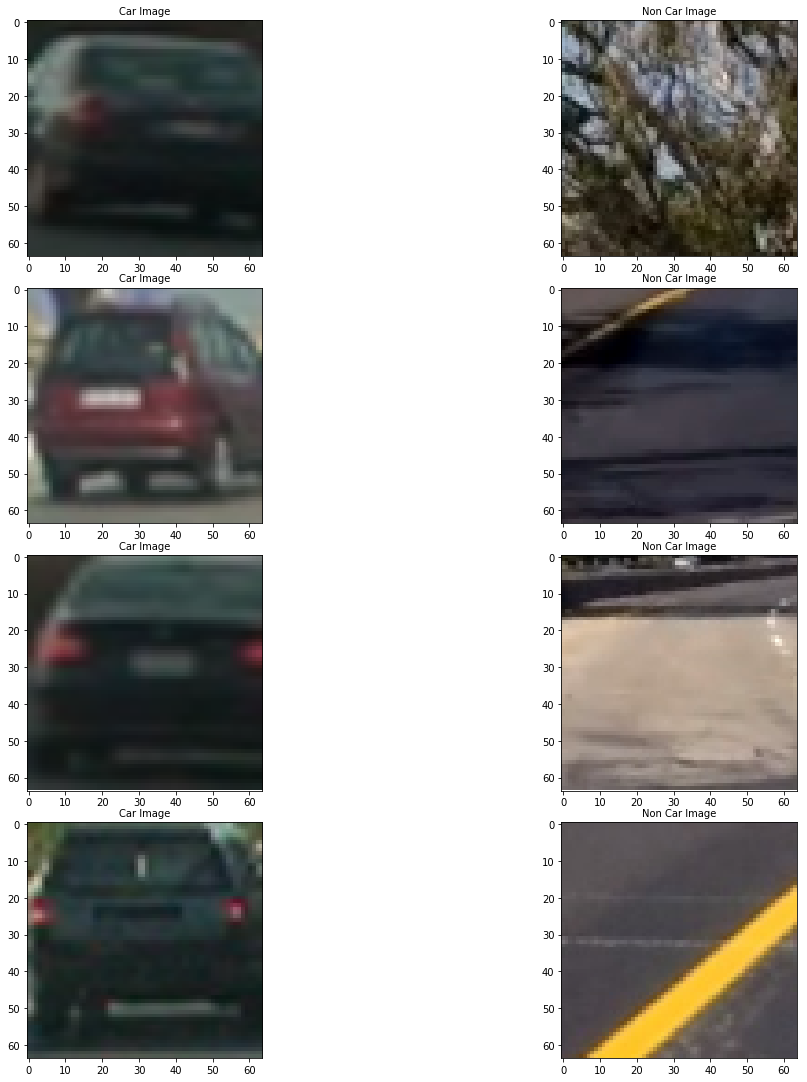

In [6]:
f,ax = plt.subplots(4,2, figsize=(15,15))
f.tight_layout()
ax[0][0].set_title('Car Image', fontsize=10)
ax[0][1].set_title('Non Car Image', fontsize=10)
ax[0][0].imshow(mpimg.imread(cars[5]))
ax[0][1].imshow(mpimg.imread(notcars[5]))
ax[1][0].set_title('Car Image', fontsize=10)
ax[1][1].set_title('Non Car Image', fontsize=10)
ax[1][0].imshow(mpimg.imread(cars[51]))
ax[1][1].imshow(mpimg.imread(notcars[51]))
ax[2][0].set_title('Car Image', fontsize=10)
ax[2][1].set_title('Non Car Image', fontsize=10)
ax[2][0].imshow(mpimg.imread(cars[500]))
ax[2][1].imshow(mpimg.imread(notcars[500]))
ax[3][0].set_title('Car Image', fontsize=10)
ax[3][1].set_title('Non Car Image', fontsize=10)
ax[3][0].imshow(mpimg.imread(cars[225]))
ax[3][1].imshow(mpimg.imread(notcars[225]))

## Necessary functions for the feature extraction

In [9]:
#Define functions that will be used later
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    fhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range) #First channel histogram
    shist = np.histogram(img[:,:,1], bins=nbins, range=bins_range) # Second channel histogram
    thist = np.histogram(img[:,:,2], bins=nbins, range=bins_range) # Third channel histogram
    # Generating bin centers
    bin_edges = fhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((fhist[0], shist[0], thist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features, fhist, shist, thist, bin_centers

def bin_spatial_features(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
     if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
     else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def extract_features_hog(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert to RGB color space
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

def color_hist_features(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [10]:
# def convert_color(img, conv='RGB2YCrCb'):
#     '''
#     Helper function to change the colorspace of an image
#     '''
#     if conv == 'RGB2YCrCb':
#         return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
#     if conv == 'BGR2YCrCb':
#         return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
#     if conv == 'RGB2LUV':
#         return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
#                         vis=False, feature_vec=True):
#     '''
#     Function to extract the hog features from an image
#     '''
#     # Call with two outputs if vis==True
#     if vis == True:
#         features, hog_image = hog(img, orientations=orient, 
#                                   pixels_per_cell=(pix_per_cell, pix_per_cell),
#                                   cells_per_block=(cell_per_block, cell_per_block), 
#                                   transform_sqrt=True, 
#                                   visualise=vis, feature_vector=feature_vec)
#         return features, hog_image
#     # Otherwise call with one output
#     else:      
#         features = hog(img, orientations=orient, 
#                        pixels_per_cell=(pix_per_cell, pix_per_cell),
#                        cells_per_block=(cell_per_block, cell_per_block), 
#                        transform_sqrt=True, 
#                        visualise=vis, feature_vector=feature_vec)
#         return features
    
# def bin_spatial(img, size=(32, 32)):
#     '''
#     Function returns the binned color features
#     '''
#     color1 = cv2.resize(img[:,:,0], size).ravel()
#     color2 = cv2.resize(img[:,:,1], size).ravel()
#     color3 = cv2.resize(img[:,:,2], size).ravel()
#     return np.concatenate((color1, color2, color3))

# def color_hist(img, nbins=32):
#     '''
#     Calculate the histogram of the color channels of the image
#     and return the three histograms concatenated
#     '''
#     # Compute the histogram of the color channels separately
#     channel1_hist = np.histogram(img[:,:,0], bins=nbins)
#     channel2_hist = np.histogram(img[:,:,1], bins=nbins)
#     channel3_hist = np.histogram(img[:,:,2], bins=nbins)
#     # Concatenate the histograms into a single feature vector
#     hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
#     # Return the individual histograms, bin_centers and feature vector
#     return hist_features

# def extract_features(imgs, color_space='RGB', spatial_size=(32,32), hist_bins=32,
#                      orient = 9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
#                      spatial_feat=True, hist_feat=True, hog_feat=True):
#     features = []
#     for file in imgs:
#         file_features = []
#         image = mpimg.imread(file)
#         if color_space != 'RGB':
#             if color_space == 'HSV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif color_space == 'LUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif color_space == 'HLS':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif color_space == 'YUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#             elif color_space == 'YCrCb':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
#         else:
#             feature_image = np.copy(image)   
#         if spatial_feat == True:
#             spatial_features = bin_spatial(feature_image, size=spatial_size)
#             file_features.append(spatial_features)
#         if hist_feat == True:
#             # Apply color_hist()
#             hist_features = color_hist(feature_image, nbins=hist_bins)
#             file_features.append(hist_features)
#         if hog_feat == True:
#         # Call get_hog_features() with vis=False, feature_vec=True
#             if hog_channel == 'ALL':
#                 hog_features = []
#                 for channel in range(feature_image.shape[2]):
#                     hog_features.append(get_hog_features(feature_image[:,:,channel], 
#                                         orient, pix_per_cell, cell_per_block, 
#                                         vis=False, feature_vec=True))
#                 hog_features = np.ravel(hog_features)        
#             else:
#                 hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                             pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#             # Append the new feature vector to the features list
#             file_features.append(hog_features)
#         features.append(np.concatenate(file_features))
#     # Return list of feature vectors
#     return features

# def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
#                     xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
#     '''
#     Define a function that takes an image,
#     start and stop positions in both x and y, 
#     window size (x and y dimensions),  
#     and overlap fraction (for both x and y)
#     '''
#     # If x and/or y start/stop positions not defined, set to image size
#     if x_start_stop[0] == None:
#         x_start_stop[0] = 0
#     if x_start_stop[1] == None:
#         x_start_stop[1] = img.shape[1]
#     if y_start_stop[0] == None:
#         y_start_stop[0] = 0
#     if y_start_stop[1] == None:
#         y_start_stop[1] = img.shape[0]
#     # Compute the span of the region to be searched    
#     xspan = x_start_stop[1] - x_start_stop[0]
#     yspan = y_start_stop[1] - y_start_stop[0]
#     # Compute the number of pixels per step in x/y
#     nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
#     ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
#     # Compute the number of windows in x/y
#     nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
#     ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
#     nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
#     ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
#     # Initialize a list to append window positions to
#     window_list = []
#     # Loop through finding x and y window positions
#     # Note: you could vectorize this step, but in practice
#     # you'll be considering windows one by one with your
#     # classifier, so looping makes sense
#     for ys in range(ny_windows):
#         for xs in range(nx_windows):
#             # Calculate window position
#             startx = xs*nx_pix_per_step + x_start_stop[0]
#             endx = startx + xy_window[0]
#             starty = ys*ny_pix_per_step + y_start_stop[0]
#             endy = starty + xy_window[1]
            
#             # Append window position to list
#             window_list.append(((startx, starty), (endx, endy)))
#     # Return the list of windows
#     return window_list

# def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
#     '''
#     Function to draw the bounding boxes on the image
#     '''
#     # Make a copy of the image
#     imcopy = np.copy(img)
#     # Iterate through the bounding boxes
#     for bbox in bboxes:
#         print(bbox)
#         # Draw a rectangle given bbox coordinates
#         cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
#     # Return the image copy with boxes drawn
#     return imcopy

## Visualize HOG Features

/home/saransh/anaconda3/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


 No. of features for pix_per_cell-  8 cell_per_block - 1 is 576
 No. of features for pix_per_cell-  16 cell_per_block - 1 is 144
 No. of features for pix_per_cell-  8 cell_per_block - 2 is 1764
 No. of features for pix_per_cell-  16 cell_per_block - 2 is 324


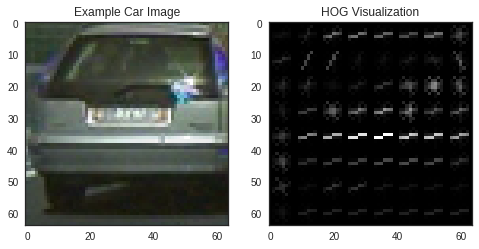

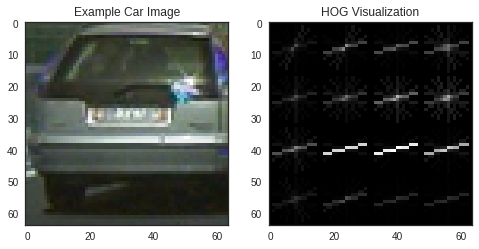

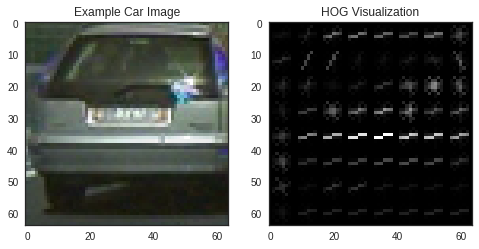

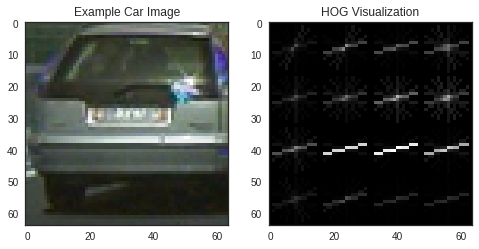

In [13]:
#Extract hog features and display
pix_per_cell = [8,16,8,16]
cell_per_block = [1,1,2,2]
orient = [9,9,9,9]

for i in range(len(pix_per_cell)):
#Input is an image of single channel or gray
    car_ind = 1167
    car_image = cv2.imread(cars[car_ind])

    gray = cv2.cvtColor(car_image, cv2.COLOR_BGR2GRAY)
    features, hog_image = get_hog_features(gray, orient[i], pix_per_cell[i], cell_per_block[i],
                             vis=True, feature_vec=False)
    feature_flatten = features.ravel()
    # If feature_vector=True then hog will automatically ravel

    # Plot the examples
    with sns.axes_style("white"):
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(car_image, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(122)
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG Visualization')
        print(" No. of features for pix_per_cell- ", pix_per_cell[i], "cell_per_block -", cell_per_block[i], "is", len(feature_flatten))

## Visualize the spatial binning features

Num features 768
44.0520833333


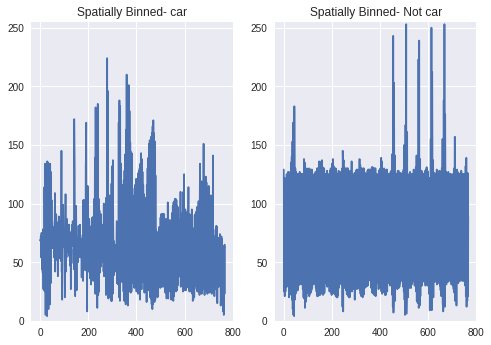

In [15]:
#Look at color features
#Spatial binned features comparison for car and notcar

def bin_spatial(img, color_space='RGB', size=(16, 16)): 
    if color_space!= 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img,cv2.COLOR_RGB2LUV)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
    resize = cv2.resize(feature_image, size)
    features = resize.ravel()
    
    # Return the feature vector
    return features

car_ind = 1167
car_image = cv2.imread(cars[car_ind])
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)

notcar_image = cv2.imread(notcars[car_ind])
notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_BGR2RGB)

spatial_car = bin_spatial(car_image, color_space='HSV', size=(16, 16))
spatial_notcar = bin_spatial(notcar_image, color_space='HSV', size=(16, 16))
delta = np.asarray(spatial_car).astype(float) - np.asarray(spatial_notcar).astype(float) 

# Plot features
plt.figure(figsize=(20,20))
fig = plt.figure()
a=fig.add_subplot(121)
plt.plot(spatial_car)
a.set_ylim([0, 255])
a.set_title('Spatially Binned- car')

a=fig.add_subplot(122)
plt.plot(spatial_notcar)
a.set_ylim([0, 255])
a.set_title('Spatially Binned- Not car')

# a=fig.add_subplot(133)
# plt.plot(delta)
# a.set_title('Delta')

print("Num features", len(spatial_car))
print(np.sum(np.absolute(delta))/len(spatial_car))

#HSV - 25 
#RGB - 27 
#HLS - 21

In [16]:
#Function reads images, extract features and returns a list of feature vectors
def extract_features_color(imgs, cspace='HLS',spatial_size=(16, 16),
                        hist_bins=16, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert to RGB color space
        
        spatial_features = bin_spatial(image, color_space=cspace, size= spatial_size)
        hist_features = color_hist_features(image, nbins=hist_bins, bins_range=hist_range)
    
        features.append(np.concatenate((spatial_features, hist_features)))

        
    return features

car_features_color = extract_features_color(cars, cspace='RGB', spatial_size=(16, 16), hist_bins=32, hist_range=(0, 256))

notcar_features_color = extract_features_color(notcars, cspace='RGB', spatial_size=(16, 16), hist_bins=32, hist_range=(0, 256))

print(len(car_features_color), len(notcar_features_color))
print(len(car_features_color[0]), len(notcar_features_color[0]))

8792 8968
864 864


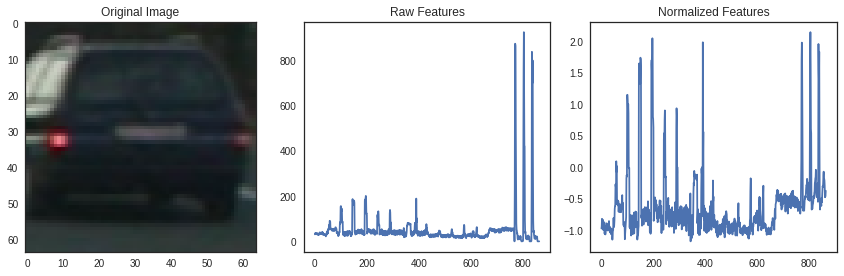

In [17]:
from sklearn.preprocessing import StandardScaler
if len(car_features_color) > 0:
    # Create an array stack of feature vectors
    X_color = np.vstack((car_features_color, notcar_features_color)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_color)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X_color)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    with sns.axes_style("white"):
        fig = plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.imshow(mpimg.imread(cars[car_ind]))
        plt.title('Original Image')
        plt.subplot(132)
        plt.plot(X_color[car_ind])
        plt.title('Raw Features')
        plt.subplot(133)
        plt.plot(scaled_X[car_ind])
        plt.title('Normalized Features')
        fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [18]:
#Training using color and HOG features
#Selected color features - cspace = 'RGB' and spatial_size = 16,16

def extract_features(imgs, color_space='RGB', spatial_size=(16, 16),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert to RGB color space
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial_features(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist_features(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Training SVM for Vehicle Detection

In [19]:
# Train classifier using HOG and color features

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time
from sklearn.cross_validation import train_test_split

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell #16
cell_per_block = 1 # HOG cells per block #2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

#Tried YCrCb, 8, 1 _ good performance 
#Tried YCrCb, 8, 2 _ good performance but very slow

/home/saransh/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/saransh/anaconda3/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 16 pixels per cell and 1 cells per block
Feature vector length: 432
0.91 Seconds to train SVC...
Test Accuracy of SVC =  0.9797
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  1.  0.  0.  0.]
0.00245 Seconds to predict 10 labels with SVC


In [26]:
# Saving the model
filename = 'final_model.sav'
pickle.dump(svc, open(filename, 'wb'))

In [18]:
# Load the model
# filename = 'final_model.sav'
# svc = pickle.load(open(filename,'rb'))

In [20]:
svc

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Other necessary helper functions

In [21]:
#Define functions to extract features from test images

def single_img_features(img, color_space='HSV', spatial_size=(16, 16), 
                        hist_bins=16, orient=6, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=2,
                        spatial_feat=False, hist_feat=False, hog_feat=True): 
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial_features(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist_features(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [22]:
##Sliding window implementation
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Sliding Window Approach

195
75
76
9
Windows Final 355


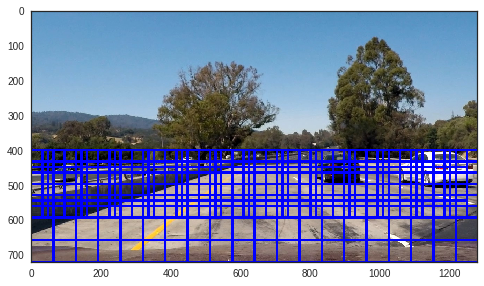

In [24]:
image = cv2.imread('./test_images/test1.jpg')
#image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

xy_window = [(64,64), (96,96), (128,128), (256,256)]
y_start_stop = [[400, 600], [400, 600], [400, None], [400, None]]

windows_temp = []
for i in range(len(xy_window)):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop[i], 
                        xy_window=xy_window[i], xy_overlap=(0.5, 0.5))
    print(len(windows))
    windows_temp.append(windows) 

#Flatten windows_temp
windows_final = sum(windows_temp, [])

print("Windows Final",len(windows_final))
window_img = draw_boxes(image, windows_final, color=(0, 0, 255), thick=6)   
with sns.axes_style("white"):
    plt.imshow(window_img)

Will only apply the sliding window to this selected part of the window

/home/saransh/anaconda3/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


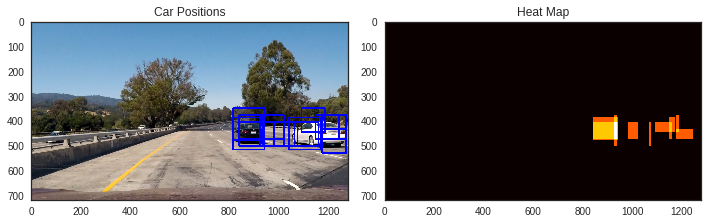

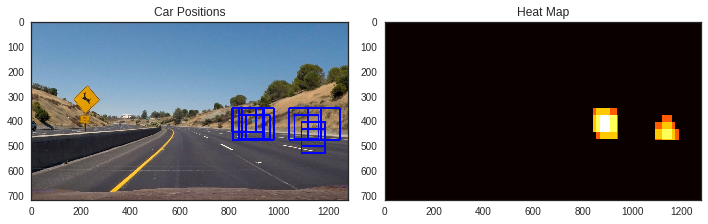

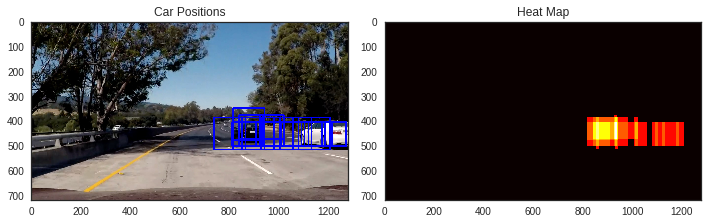

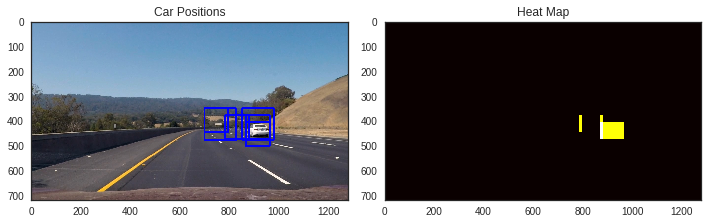

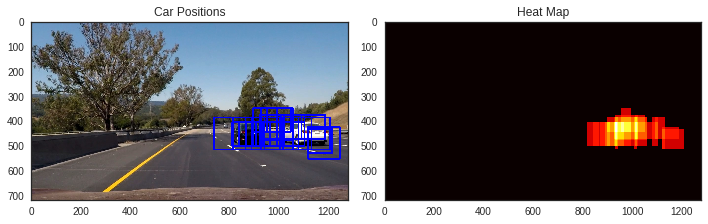

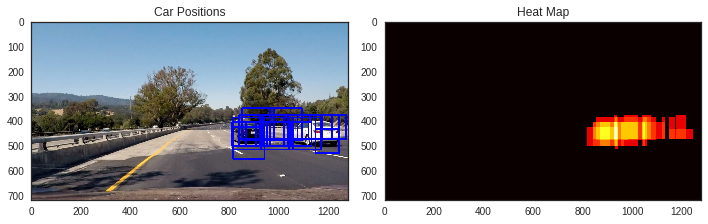

In [30]:
files = glob.glob('./test_images/*.jpg')

for file in files:
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    xy_window = [(96,96),(128,128)]
    y_start_stop = [[350, 600], [350, None]]

    windows_temp = []
    for i in range(len(xy_window)):
        windows = slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stop[i], 
                            xy_window=xy_window[i], xy_overlap=(0.7, 0.7))
        #print(len(windows))
        windows_temp.append(windows) 

    #Flatten windows_temp
    windows_final = sum(windows_temp, [])
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 16 # HOG pixels per cell
    cell_per_block = 1 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = False # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [300, None] # Min and max in y to search in slide_window()

    hot_windows = search_windows(image, windows_final, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)     
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    with sns.axes_style("white"):
        fig = plt.figure(figsize=(10, 10))
        plt.subplot(121)
        plt.imshow(window_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()

## Pipeline for video implementation

In [31]:
def hot_windows(input_image, windows, classifier, scaler, draw=True):
    """Adds bounding boxes from `input_image` (one array of arrays) to
    the global variable `bboxes_list`'.
    If `draw` is True, returns image overlaid with bounding boxes.
    """
    #global hot_windows_list
    #xy_window = [(96,96), (128,128), (256,256)]
    #y_start_stop = [[400, 650], [400, None], [400, None]]
    
    #Reduced list of windows to improve computation 
    xy_window = [(96,96), (128,128)]
    y_start_stop = [[390, 650], [390, None]]

    windows_temp = []
    for i in range(len(xy_window)):
        windows = slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stop[i], 
                            xy_window=xy_window[i], xy_overlap=(0.7, 0.7))
        #print(len(windows))
        windows_temp.append(windows) 

    #Flatten windows_temp
    windows_final = sum(windows_temp, [])
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 16 # HOG pixels per cell
    cell_per_block = 1 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = False # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [300, None] # Min and max in y to search in slide_window()


    hot_windows = search_windows(input_image, windows_final, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
   
    #hot_windows_list.append(hot_windows)
    #print("Hot windows: ", hot_windows)
    if draw == True:
        draw_image = np.copy(input_image)
        window_img = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=6)
        return window_img
    
    return hot_windows

In [32]:
def process_image(image, n_frames=20, threshold=22):  
     
    hot_windows_temp =[]
    global hot_windows_list
    global windows
    global hot_windows_final
   
    windows = hot_windows(image, windows, svc, X_scaler, draw=False)
    hot_windows_list.append(windows)
   
    if len(hot_windows_list) <= n_frames:
         hot_windows_final = sum(hot_windows_list, []) # Add windows from all available frames
    
    #Look at last n frames and append all hot windows found
    else: 
        for val in hot_windows_list[(len(hot_windows_list) - n_frames -1) : (len(hot_windows_list)-1)]:
            hot_windows_temp.append(val)
    #Flatten this list
        hot_windows_final = sum(hot_windows_temp, [])
    
    #draw_image = np.copy(image)
    #window_img = draw_boxes(draw_image, hot_windows_final, color=(0, 0, 255), thick=6)   
    
    #Create a frame_heatmap
    frame_heatmap = np.zeros_like(image[:,:,0])
    
    frame_heatmap = add_heat(frame_heatmap, hot_windows_final)
    
    # Apply threshold
    frame_heatmap = apply_threshold(frame_heatmap, threshold)
    
    labels = label(frame_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    plt.imshow(draw_img)
    return draw_img

[MoviePy] >>>> Building video vehicle_detection.mp4
[MoviePy] Writing video vehicle_detection.mp4


100%|█████████▉| 1260/1261 [11:28<00:00,  1.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_detection.mp4 

CPU times: user 11min 22s, sys: 2.78 s, total: 11min 25s
Wall time: 11min 29s


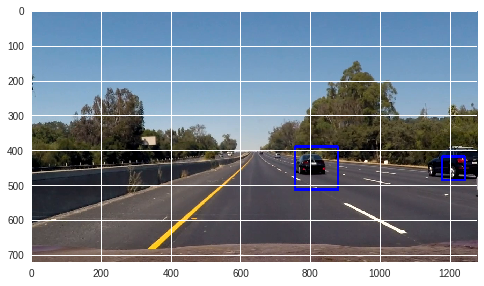

In [34]:
hot_windows_list = []
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video = VideoFileClip("project_video.mp4")

video.save_frame("extra/frame.jpeg")
video.save_frame("extra/frame20.jpeg", t=20)
video.save_frame("extra/frame21.jpeg", t=21)
video.save_frame("extra/frame22.jpeg", t=22)

project_clip = video.fl_image(process_image) #NOTE: this function expects color images!!


output = "vehicle_detection.mp4"
%time project_clip.write_videofile(output, audio=False)